In [20]:
%matplotlib inline
import numpy as np
import theano
import theano.tensor as T
import operator
import matplotlib.pyplot as plt
import timeit
import cPickle as pickle
import pandas as pd

import cartpole_lib as cp

In [2]:
%cd theano-rnn/
import rnn_minibatch as rnn
%cd ..

/Users/jtobin/Documents/Courses/Robotics/FinalProject/crossrobot/theano-rnn


In [8]:
# Load policy.
# This policy was generated from cartpoles of mass (5, 0.5), (7.5, 0.75), (10, 1), (15, 1.5), (20, 2)
with open('crobot_controller1.pickle', 'r') as input_file:
    policy = pickle.load(input_file)

In [9]:
# Define a function that calculates the nnet action
feed_forward = theano.function(inputs = [policy.input],
                               outputs = policy.output)

In [219]:
# Find the range of cart and pole masses for which we can use this controller
dt, eps = 0.1, 0.1
table_mass_pos_u = np.zeros([60,12])
i0 = 0
for i in np.arange(0.5,30.5,0.5):
    j0 = 0
    for j in [np.pi - np.pi/3, np.pi - np.pi/4, np.pi - np.pi/5, np.pi - np.pi/6,  np.pi - np.pi/7, np.pi - np.pi/8,
              np.pi + np.pi/8, np.pi + np.pi/7, np.pi + np.pi/6, np.pi + np.pi/5, np.pi + np.pi/4, np.pi + np.pi/3]:
        x_sim = np.zeros([6,500])
        x_sim[:,0] = np.array([0, j, 0, 0, i, i/10.])

        u_sim = np.zeros([500,])
        u_sim[0] = feed_forward(x_sim[:,0].reshape([1,6]))

        for t in range(499):
            x_sim[:,t+1] = cp.sim_cartpole_ext(x_sim[:,t], u_sim[t], dt)
            u_sim[t+1] = feed_forward(x_sim[:,t+1].reshape([1,6]))
        table_mass_pos_u[i0,j0] = x_sim[1,-1]
        j0 += 1
    i0 +=1
    

In [225]:
cols = ['-pi/3','-pi/4', '-pi/5', '-pi/6', '-pi/7', '-pi/8',
        'pi/8', 'pi/7', 'pi/6', 'pi/5', 'pi/4', 'pi/3']
formatted_table = np.pi - pd.DataFrame(table_mass_pos_u, columns = cols)
formatted_table = formatted_table.set_index(np.arange(0.5,30.5, 0.5))
formatted_table = formatted_table.fillna(-1000)
formatted_table = -formatted_table.abs()


In [224]:
def plot_heatmap(formatted_table, figsize=(8,11)):
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(formatted_table, cmap=plt.cm.Greens, alpha=0.8, vmin=-1000)
    # Format
    fig = plt.gcf()
    fig.set_size_inches(figsize[0], figsize[1])

    # turn off the frame
    ax.set_frame_on(False)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(formatted_table.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(formatted_table.shape[1]) + 0.5, minor=False)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # Set the labels

    # label source:https://en.wikipedia.org/wiki/Basketball_statistics
    labels = formatted_table.columns

    # note I could have used nba_sort.columns but made "labels" instead
    ax.set_xticklabels(labels, minor=False)
    ax.set_yticklabels(formatted_table.index, minor=False)

    # rotate the
    plt.xticks(rotation=60)

    ax.grid(False)

    # Turn off all the ticks
    ax = plt.gca()

    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
        
    plt.xlabel('Starting position', )
    plt.ylabel('Cart mass')
    
    

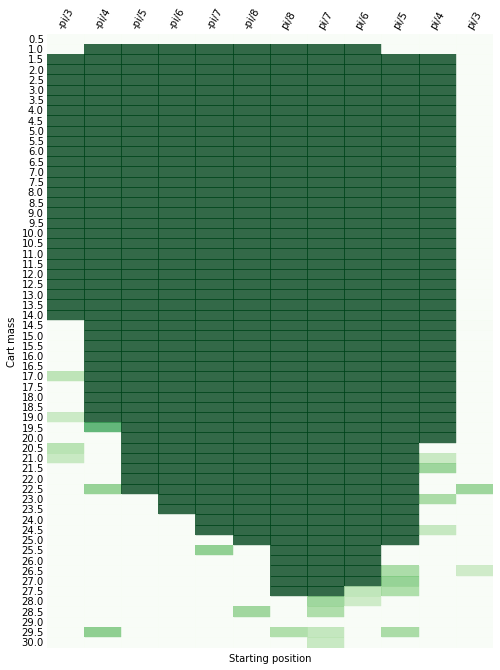

In [226]:
plot_heatmap(formatted_table)


In [86]:
# Plot the robustness to errors in mass estimation
table_mass_err = np.zeros([60, 39])
i0 = 0
for i in np.arange(0.5,30.5,0.5):
    j0 = 0
    for j in np.arange(-0.95, 1, 0.05): # percentage error in mass estimation
        i_adj = (1+j)*i
        x_sim = np.zeros([6,500])
        x_sim_real = np.zeros([6,500])
        x_sim[:,0] = np.array([0, np.pi - np.pi/4, 0, 0, i, i/10.])
        x_sim_real[:,0] = np.array(x_sim[:,0])
        x_sim_real[-2,0] = i_adj
        x_sim_real[-1,0] = i_adj/10.

        u_sim = np.zeros([500,])
        u_sim[0] = feed_forward(x_sim[:,0].reshape([1,6]))

        for t in range(499):
            x_sim_real[:,t+1] = cp.sim_cartpole_ext(x_sim_real[:,t], u_sim[t], dt)
            x_sim[:,t+1] = np.array([x_sim_real[:,t+1]])
            x_sim[-2,t+1] = i
            x_sim[-1,t+1] = i/10.
            u_sim[t+1] = feed_forward(x_sim[:,t+1].reshape([1,6]))
        table_mass_err[i0, j0] = x_sim[1,-1]
        j0 += 1
    i0 += 1

In [87]:
cols = np.arange(-0.95, 1, 0.05)
formatted_table_err = np.pi - pd.DataFrame(table_mass_err, columns = cols)
formatted_table_err = formatted_table_err.set_index(np.arange(0.5,30.5, 0.5))
formatted_table_err = formatted_table_err.fillna(-1000)
formatted_table_err = -formatted_table_err.abs()


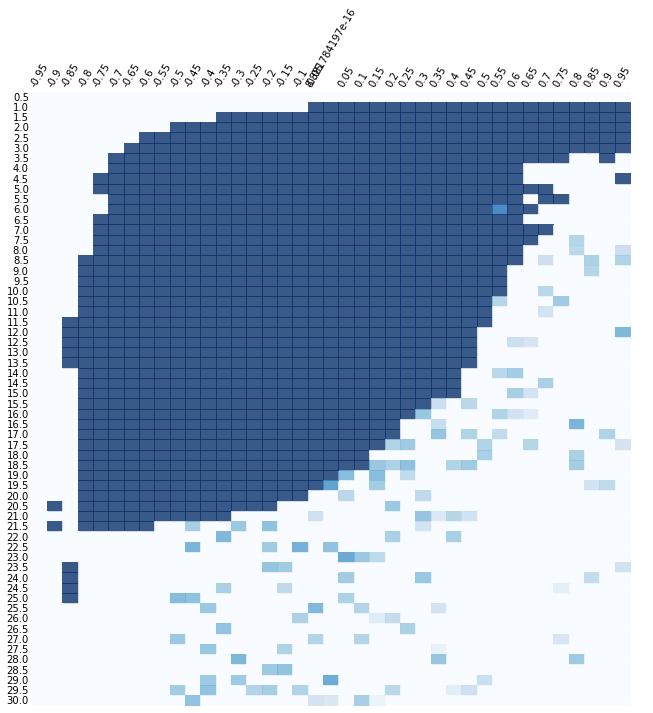

In [88]:
plot_heatmap(formatted_table_err, figsize = (11,11))


In [99]:
# Plot the robustness to different pole mass
table_cartm_polem = np.zeros([60, 61])
i0 = 0
for i in np.arange(0.5,30.5,0.5):
    j0 = 0
    for j in np.arange(-1, 5.1, 0.1): # percentage difference from 10% in pole mass
        i_adj = (1+j)*i
        x_sim = np.zeros([6,500])
        x_sim_real = np.zeros([6,500])
        x_sim[:,0] = np.array([0, np.pi - np.pi/4, 0, 0, i, 0.1*i_adj])
        
        u_sim = np.zeros([500,])
        u_sim[0] = feed_forward(x_sim[:,0].reshape([1,6]))

        for t in range(499):
            x_sim[:,t+1] = cp.sim_cartpole_ext(x_sim[:,t], u_sim[t], dt)
            u_sim[t+1] = feed_forward(x_sim[:,t+1].reshape([1,6]))
        table_cartm_polem[i0, j0] = x_sim[1,-1]
        j0 += 1
    i0 += 1

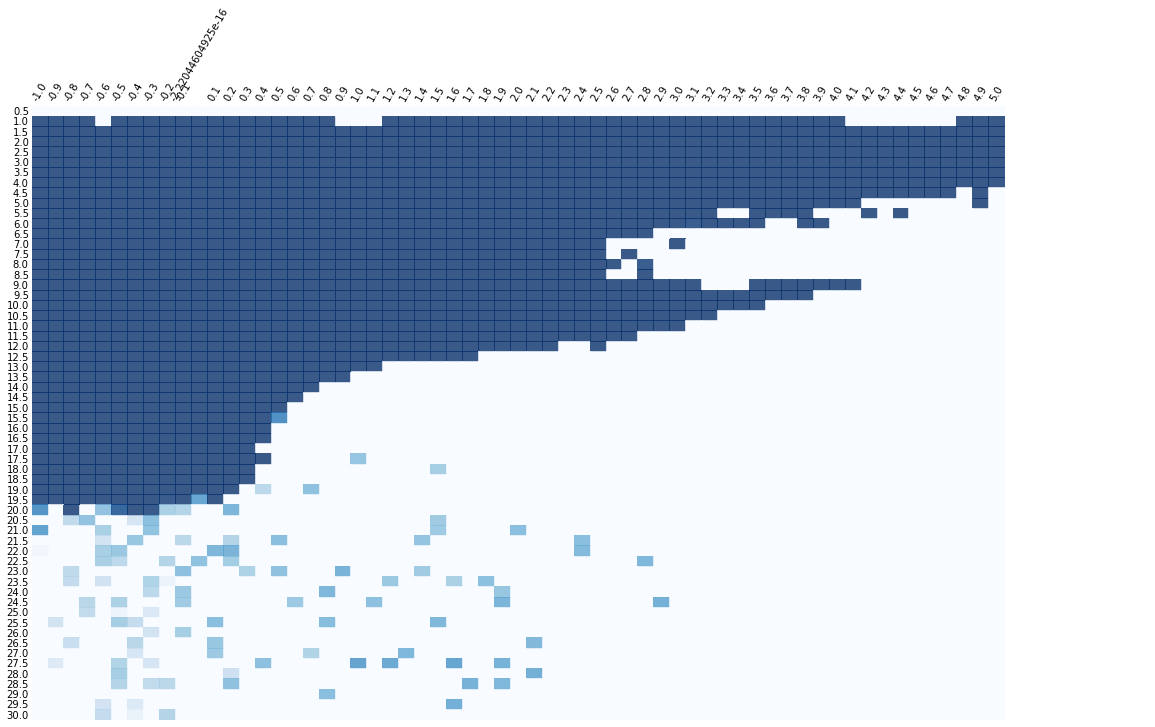

In [103]:
cols = np.arange(-1, 5.1, 0.1)
formatted_table_m = np.pi - pd.DataFrame(table_cartm_polem, columns = cols)
formatted_table_m = formatted_table_m.set_index(np.arange(0.5,30.5, 0.5))
formatted_table_m = formatted_table_m.fillna(-1000)
formatted_table_m= -formatted_table_m.abs()
plot_heatmap(formatted_table_m, figsize = (20,11))

In [98]:
np.arange(-1,5.1,0.1).shape

(61,)

In [104]:
with open('mass_estimator.pickle', 'r') as input_file:
    mass_estimator = pickle.load(input_file)

In [108]:


uref = 0.
A1, B1, c1 = cp.linearize_cartpole_ext(xref1, uref, dt, eps)
K1, P1, Quu1 = cp.lqr_infinite_horizon(A1, B1, Q, R)

In [190]:
def estimate_cartpole_mass(starting_pos, mass_estimator):
    # LQR Paramters
    dt, eps = 0.1, 0.1
    Q = np.eye(6)
    R = np.eye(1)
    xref1 = np.array([0,np.pi,0,0,starting_pos[-2],starting_pos[-1]])
    A1, B1, c1 = cp.linearize_cartpole_ext(xref1, uref, dt, eps)
    K1, P1, Quu1 = cp.lqr_infinite_horizon(A1, B1, Q, R)
    
    # Generate a trajectory to use to estimate the mass
    x_traj, u_traj = cp.gen_traj_guidance_ext(starting_pos, K1, Quu1)

    # Clean up the trajectory for use with the mass estimator
    x_traj = x_traj.T
    u_traj = u_traj.T
    input_data = np.c_[x_traj[:,:4], u_traj]
    target = x_traj[:,4:]
    n_steps = 20
    total_steps = x_traj.shape[0] / n_steps
    seq = np.zeros([n_steps, total_steps, 5])
    for i in range(total_steps):
        seq[:,i,:] = input_data[i*n_steps:(i+1)*n_steps,:]
        
    return mass_estimator.predict(seq)[-1,:,:].mean(axis=0)

In [204]:
starting_pos = np.array([0, np.pi - np.pi/7, 0, 0, 5, .7])

def test_starting_pos(starting_position, mass_estimator, feed_forward):
    mass_est = estimate_cartpole_mass(starting_position, mass_estimator)
    x_sim = np.zeros([6,500])
    x_sim[:,0] = starting_position

    x_sim_est = np.zeros([6,500])
    x_sim_est[:,0] = starting_position
    x_sim_est[-1,0] = mass_est[-1]
    x_sim_est[-2,0] = mass_est[-2]

    u_sim = np.zeros([500,])
    u_sim[0] = feed_forward(x_sim[:,0].reshape([1,6]))

    for t in range(499):
        x_sim[:,t+1] = cp.sim_cartpole_ext(x_sim[:,t], u_sim[t], dt)

        x_sim_est[:,t+1] = np.array(x_sim[:,t+1])
        x_sim_est[-1,t+1] = mass_est[-1]
        x_sim_est[-2,t+1] = mass_est[-2]

        u_sim[t+1] = feed_forward(x_sim_est[:,t+1].reshape([1,6]))
        
    return x_sim[1,-1]

In [205]:
# Find the range of cart and pole masses for which we can use this controller for unknown cart/pole masses
dt, eps = 0.1, 0.1
unknown_mass_pos = np.zeros([60,12])
i0 = 0
for i in np.arange(0.5,30.5,0.5):
    j0 = 0
    for j in [np.pi - np.pi/3, np.pi - np.pi/4, np.pi - np.pi/5, np.pi - np.pi/6,  np.pi - np.pi/7, np.pi - np.pi/8,
              np.pi + np.pi/8, np.pi + np.pi/7, np.pi + np.pi/6, np.pi + np.pi/5, np.pi + np.pi/4, np.pi + np.pi/3]:
        
        starting_pos = np.array([0, j, 0, 0, i, i/10.])

        result = test_starting_pos(starting_pos, mass_estimator, feed_forward)
        unknown_mass_pos[i0,j0] = result
        j0 += 1
    i0 +=1
    

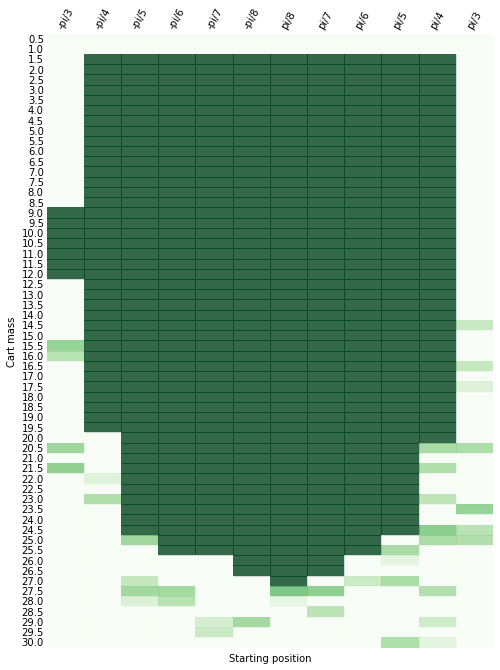

In [227]:
cols = ['-pi/3','-pi/4', '-pi/5', '-pi/6', '-pi/7', '-pi/8',
        'pi/8', 'pi/7', 'pi/6', 'pi/5', 'pi/4', 'pi/3']
formatted_table = np.pi - pd.DataFrame(unknown_mass_pos, columns = cols)
formatted_table = formatted_table.set_index(np.arange(0.5,30.5, 0.5))
formatted_table = formatted_table.fillna(-1000)
formatted_table = -formatted_table.abs()
plot_heatmap(formatted_table, figsize = (8,11))


In [209]:
dt, eps = 0.1, 0.1
Q = np.eye(6)
R = np.eye(1)

xref1 = np.array([0,np.pi,0,0,10,1])
uref = 0.
A1, B1, c1 = cp.linearize_cartpole_ext(xref1, uref, dt, eps)
K1, P1, Quu1 = cp.lqr_infinite_horizon(A1, B1, Q, R)

In [210]:
# Find the range of cart and pole masses for which LQR works
dt, eps = 0.1, 0.1
LQR_mass_pos = np.zeros([60,12])
i0 = 0
for i in np.arange(0.5, 30.5,0.5):
    j0 = 0
    for j in [np.pi - np.pi/3, np.pi - np.pi/4, np.pi - np.pi/5, np.pi - np.pi/6,  np.pi - np.pi/7, np.pi - np.pi/8,
              np.pi + np.pi/8, np.pi + np.pi/7, np.pi + np.pi/6, np.pi + np.pi/5, np.pi + np.pi/4, np.pi + np.pi/3]:
        
        starting_pos = np.array([0, j, 0, 0, i, i/10.])
        
        x_sim4 = np.zeros([6,500])
        x_sim4[:,0] = starting_pos

        u_sim4 = np.zeros([500,])
        u_sim4[0] = np.dot(K1, x_sim4[:,0] - xref1)

        for t in range(499):
            x_sim4[:,t+1] = cp.sim_cartpole_ext(x_sim4[:,t], u_sim4[t], dt)
            u_sim4[t+1] = np.dot(K1, x_sim4[:,t+1] - xref1)
        result = x_sim4[1,-1]
        LQR_mass_pos[i0,j0] = result
        j0 += 1
    i0 +=1
    
    

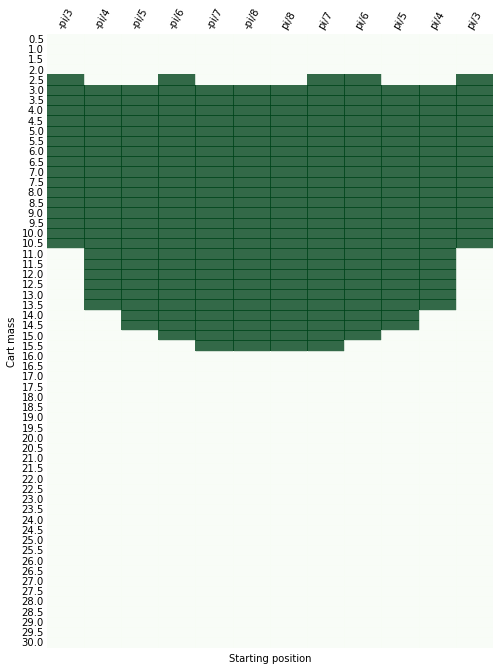

In [228]:
cols = ['-pi/3','-pi/4', '-pi/5', '-pi/6', '-pi/7', '-pi/8',
        'pi/8', 'pi/7', 'pi/6', 'pi/5', 'pi/4', 'pi/3']
formatted_table = np.pi - pd.DataFrame(LQR_mass_pos, columns = cols)
formatted_table = formatted_table.set_index(np.arange(0.5,30.5, 0.5))
formatted_table = formatted_table.fillna(-1000)
formatted_table = -formatted_table.abs()
plot_heatmap(formatted_table, figsize = (8,11))

